In [1]:
import requests
from io import StringIO
import pandas as pd
from os.path import exists
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import lime
import lime.lime_tabular
import shap
from sklearn.preprocessing import StandardScaler

In [2]:
attributes = ["Status", "Duration", "CreditHistory","Purpose", "CreditAmount", "Savings", "Employement",
              "InstallementDisposableIncome", "PersonalStatus", "Debtors","PresentResidence","Property", "Age",
              "Installment", "Housing","NoCredits","Job", "NoPplMaintenance", "Phone", "ForeignWorker",
              "Classification"]

qualitative_attributes = ["Status", "CreditHistory","Purpose", "Savings", "Employement", "PersonalStatus",
                          "Debtors","Property","Installment", "Housing","Job", "Phone", "ForeignWorker",
                          "Classification"]

qualitative_attributes_index = [i for i, e in enumerate(attributes) if e in set(qualitative_attributes)]


def load_data():
    URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
    response = requests.get(URL)
    file = open("data.txt", "wb")
    file.write(response.content)
    file.close()
    
    df=pd.read_table("data.txt", delim_whitespace=True, names=attributes, index_col=False)
    df.to_csv("data_raw.csv", index_label=False)
    
    return df

if exists("data_raw.csv"):
    data_df = pd.read_csv("data_raw.csv", index_col=[0])
    print("Data loaded from csv")
else:
    data_df = load_data()
    print("Data loaded from web source")
    

data_factorized = data_df.apply(lambda x : pd.factorize(x)[0])
data_df

Data loaded from csv


,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,Employement,InstallementDisposableIncome,PersonalStatus,Debtors,...,Property,Age,Installment,Housing,NoCredits,Job,NoPplMaintenance,Phone,ForeignWorker,Classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


[]

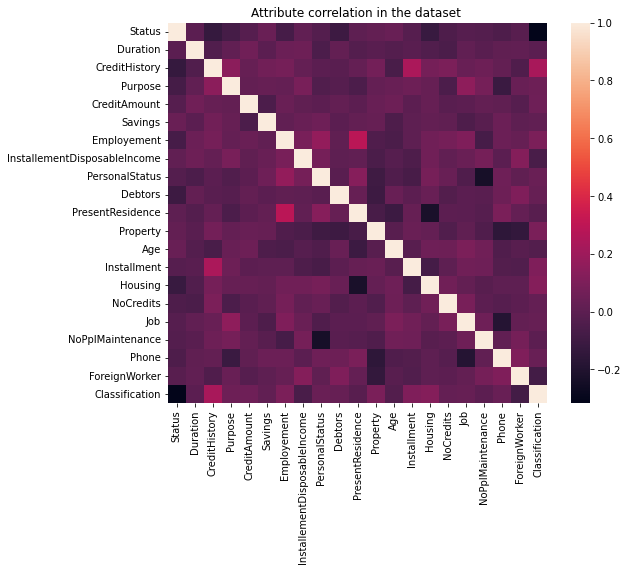

In [3]:
fig, ax = plt.subplots(figsize=(8.5,7))  
sns.heatmap(data_factorized.corr(method="pearson"), ax=ax)
plt.title("Attribute correlation in the dataset ")
plt.plot()

Now, we look at 3 protected values for bias

In [4]:
male_div_sep = data_df[data_df.PersonalStatus == 'A91']
female_div_sep_mar = data_df[data_df.PersonalStatus == 'A92']
male_sin = data_df[data_df.PersonalStatus == 'A93']
male_mar_wid = data_df[data_df.PersonalStatus == 'A94']
female_sin = data_df[data_df.PersonalStatus == 'A95']



## A91 : male : divorced/separated
## A92 : female : divorced/separated/married
## A93 : male : single
## A94 : male : married/widowed
## A95 : female : single
male_div_sep_prop = male_div_sep.value_counts("Classification")
female_div_sep_mar_prop = female_div_sep_mar.value_counts("Classification")
male_sin_prop = male_sin.value_counts("Classification")
male_mar_wid_prop = male_mar_wid.value_counts("Classification")
female_sin_prop = female_sin.value_counts("Classification")
male_prop = male_div_sep_prop + male_sin_prop + male_mar_wid_prop

Series([], dtype: int64)

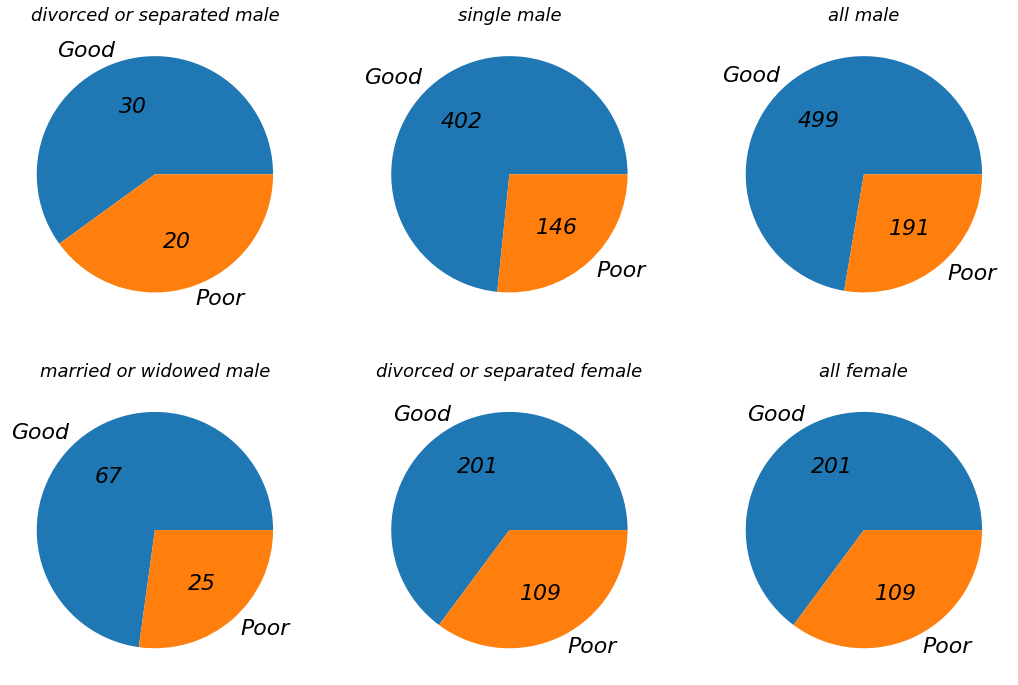

In [6]:
# For one 4-long row of plots:
fig, axes = plt.subplots(2, 3, figsize = (18,12))
plt.rcParams.update({'font.size': 22})


axes[0, 0].pie(male_div_sep_prop, labels = ['Good', 'Poor'], autopct = lambda p: round(p * male_div_sep_prop.sum() / 100))
axes[0, 1].pie(male_sin_prop, labels = ['Good', 'Poor'], autopct = lambda p: round(p * male_sin_prop.sum() / 100))
axes[1, 0].pie(male_mar_wid_prop, labels = ['Good', 'Poor'], autopct = lambda p: round(p * male_mar_wid_prop.sum() / 100))
axes[1, 1].pie(female_div_sep_mar_prop, labels = ['Good', 'Poor'], autopct = lambda p: round(p * female_div_sep_mar_prop.sum() / 100))
axes[0, 2].pie(male_prop, labels = ['Good', 'Poor'], autopct = lambda p: round(p * male_prop.sum() / 100))
axes[1, 2].pie(female_div_sep_mar_prop, labels = ['Good', 'Poor'], autopct = lambda p: round(p * female_div_sep_mar_prop.sum() / 100))
plt.rcParams.update({'font.size': 15})

axes[0, 0].set_title("divorced or separated male")
axes[0, 1].set_title("single male")
axes[1, 0].set_title("married or widowed male")
axes[1, 1].set_title("divorced or separated female")
axes[0, 2].set_title("all male")
axes[1, 2].set_title("all female")

# axes[1, 1].pie(female_sin_prop, labels = ['Good', 'Yes'], autopct = lambda p: round(p * female_sin_prop.sum() / 100))
# axes[1, 2].set_visible(False)
#axes[0, 0].set_title('% of male divorce or separated', fontsize = 12)


plt.show()

In [74]:
age_prop = pd.DataFrame(columns = ["Good", "Poor", "Proportion of good credit"])
age_prop.index.name = "Age"
for x in range(15, 80, 5):
    spec_age = data_df[(data_df.Age >= x) & (data_df.Age < (x+5))].value_counts("Classification")
    good = 0
    poor = 0
    if(data_df[(data_df.Age == x) & (data_df.Classification == 1)].shape[0] > 0):
        good += spec_age[1]
    if(data_df[(data_df.Age == x) & (data_df.Classification == 2)].shape[0] > 0):
        poor += spec_age[2]
    if(good+poor > 0):
        age_prop.loc[str(x)+"-"+str((x+4))] = [good, poor, good/(good+poor)]
age_prop

,Good,Poor,Proportion of good credit
Age,,,
20-24,87.0,60.0,0.591837
25-29,146.0,76.0,0.657658
30-34,122.0,55.0,0.689266
35-39,123.0,30.0,0.803922
40-44,70.0,28.0,0.714286
45-49,60.0,16.0,0.789474
50-54,34.0,12.0,0.739130
55-59,19.0,9.0,0.678571
60-64,21.0,7.0,0.750000


<BarContainer object of 12 artists>

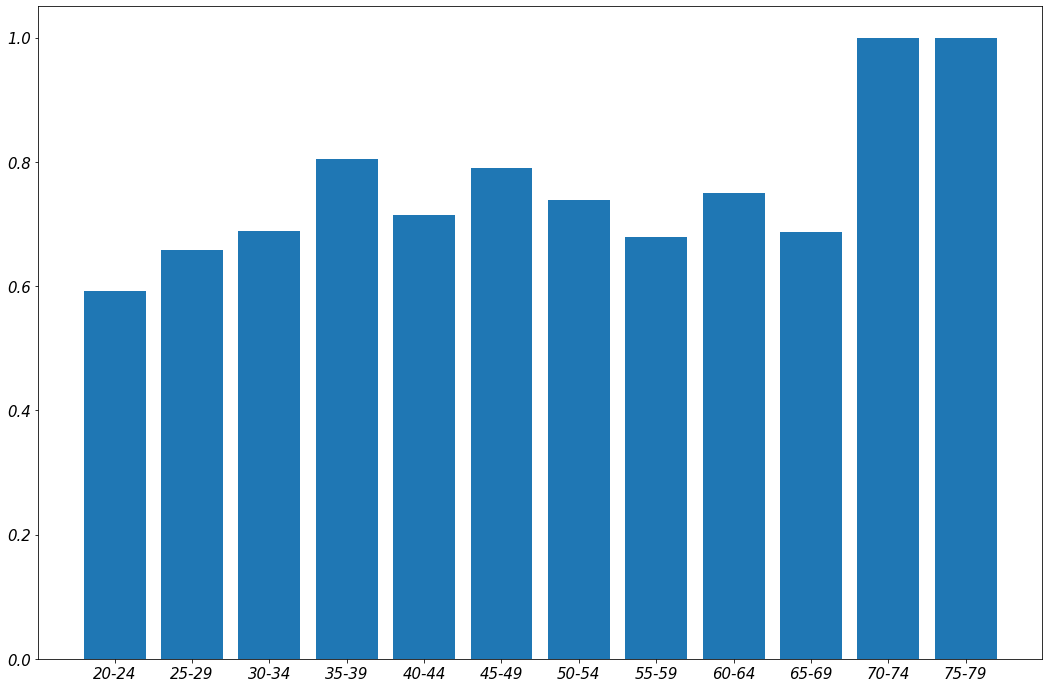

In [89]:
plt.rcParams["figure.figsize"] = (18,12)
plt.bar(age_prop.index, age_prop["Proportion of good credit"])

In [95]:
foreign_y = data_df[data_df.ForeignWorker == 'A201']
foreign_n = data_df[data_df.ForeignWorker == 'A202']
foreign_y_prop = foreign_y.value_counts("Classification")
foreign_n_prop = foreign_n.value_counts("Classification")


Text(0.5, 1.0, 'non-foreign workers')

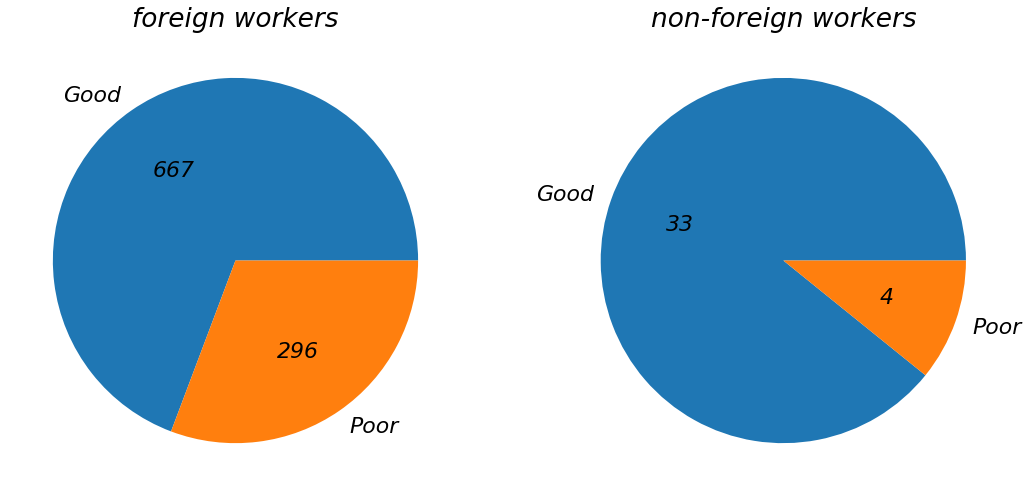

In [96]:
fig, axes = plt.subplots(1, 2, figsize = (18,12))
plt.rcParams.update({'font.size': 22})


axes[0].pie(foreign_y_prop, labels = ['Good', 'Poor'], autopct = lambda p: round(p * foreign_y_prop.sum() / 100))
axes[1].pie(foreign_n_prop, labels = ['Good', 'Poor'], autopct = lambda p: round(p * foreign_n_prop.sum() / 100))

axes[0].set_title("foreign workers")
axes[1].set_title("non-foreign workers")